# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Jan 15 15:54:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 4.99 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402452
drwxr-xr-x 2 root root      4096 Jan 15 15:54 .
drwxr-xr-x 1 root root      4096 Jan 15 15:54 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [ ]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("trafficsignyolov9").project("traffic-sign-detection-2lmuq-ysmmk")
version = project.version(2)
dataset = version.download("yolov9")

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov9 in progress : 85.0%
Version export complete for yolov9 format



Extracting Dataset Version Zip to Traffic-Sign-Detection-2 in yolov9:: 100%|██████████| 10562/10562 [00:02<00:00, 4255.60it/s]


In [ ]:
# Kiểm tra các phiên bản có sẵn trong project
project = rf.workspace("trafficsignyolov9").project("traffic-sign-detection-2lmuq-ysmmk")

# In danh sách các phiên bản
print("Available versions:")
for version in project.versions():
    print(f"Version: {version.version}, Created: {version.created}")


loading Roboflow workspace...
loading Roboflow project...
Available versions:
Version: 2, Created: 1736955265.899
Version: 1, Created: 1736880816.296


## Train Custom Model

In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 15 --img 640 --device 0 --min-items 0 --close-mosaic 8 \
--data  /content/yolov9/Traffic-Sign-Detection-2/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2025-01-15 15:58:05.577769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 15:58:05.594516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 15:58:05.600357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 15:58:05.614079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 15:58:06.793683: W tensorf

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    labels_correlogram.jpg  PR_curve.png  weights
events.out.tfevents.1736956700.461d34e94541.2240.0  labels.jpg		    R_curve.png
F1_curve.png					    opt.yaml		    results.csv
hyp.yaml					    P_curve.png		    results.png


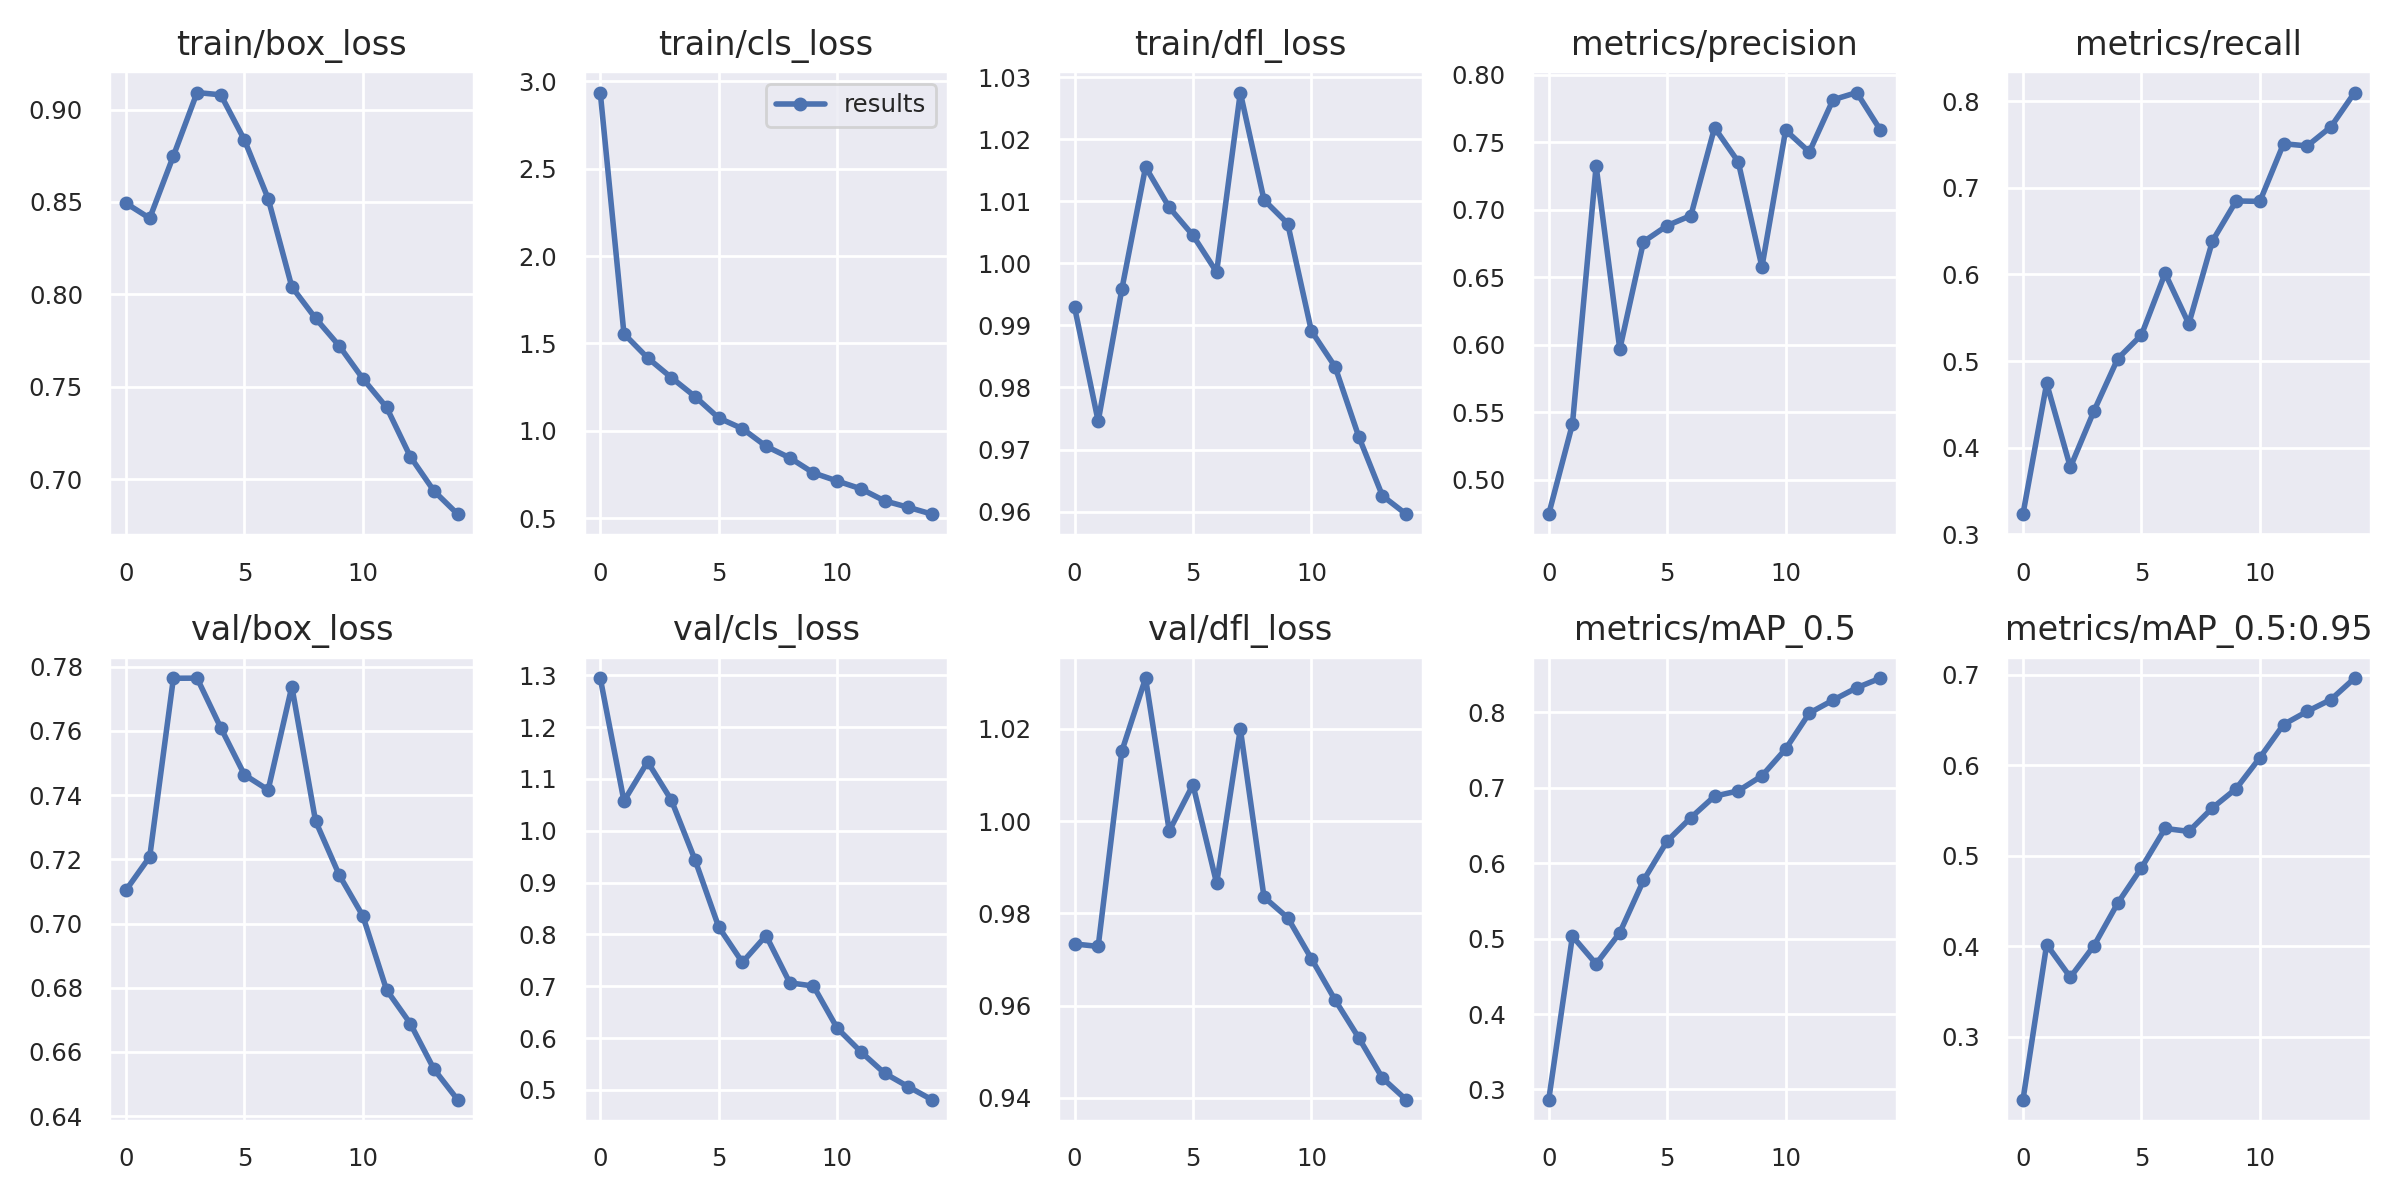

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

## Validate Custom Model

In [ ]:
!python detect.py --source /content/test.mp4 --weights '/content/yolov9/runs/train/exp/weights/best.pt' --device 0 --iou-thres 0.7


detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/test.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.7, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 

In [ ]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Traffic-Sign-Detection-2/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limit

## Inference with Custom Model

In [ ]:
!pip install -q inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.3/924.3 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

In [ ]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp")

View the status of your deployment at: https://app.roboflow.com/trafficsignyolov9/traffic-sign-detection-2lmuq-ysmmk/2
Share your model with the world at: https://universe.roboflow.com/trafficsignyolov9/traffic-sign-detection-2lmuq-ysmmk/model/2


In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="traffic-sign-detection-2lmuq/7", api_key=ROBOFLOW_API_KEY)

KeyboardInterrupt: Interrupted by user

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="A1nXgtiJdkVXD4GEHAet")
project = rf.workspace().project("traffic-sign-detection-2lmuq")
model = project.version("1").model

job_id, signed_url, expire_time = model.predict_video(
    "/content/test.mp4",
    fps=30,
    prediction_type="batch-video",
)

results = model.poll_until_video_results(job_id)

print(results)


loading Roboflow workspace...
loading Roboflow project...
Checking for video inference results for job 4b4948f1-3978-4be0-8dcc-06c93d4e1fcb every 60s
(0s): Checking for inference results
(60s): Checking for inference results
(120s): Checking for inference results
(180s): Checking for inference results
(240s): Checking for inference results
(300s): Checking for inference results
(360s): Checking for inference results
(420s): Checking for inference results
(480s): Checking for inference results
(540s): Checking for inference results
(600s): Checking for inference results
(660s): Checking for inference results
(720s): Checking for inference results
{'frame_offset': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152

**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
# import a utility function for loading Roboflow models
from inference import get_model

# define the image url to use for inference
image = "https://media.roboflow.com/inference/people-walking.jpg"

# load a pre-trained yolov8n model
model = get_model(model_id="yolov8n-640")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)


In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)